In [1]:
from modules.handlers.BinanceHandler import BinanceHandler
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import time
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
log_dir = "logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [3]:
file_path = 'btc_data.csv'
params = {
    'symbol': 'BTCUSDT',
    'timeframe': '1d',
    'file_name': file_path
}
data_handler = BinanceHandler(params)
data_handler.handle()
crypto_data = pd.read_csv(file_path)
crypto_data

,Timestamp,Open,High,Low,Close,Volume
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...,...
2324,1703721600000,43428.86,43787.57,42241.79,42563.76,35150.524850
2325,1703808000000,42563.76,43111.00,41300.00,42066.95,42597.189120
2326,1703894400000,42066.94,42612.32,41520.30,42140.28,22906.578180
2327,1703980800000,42140.29,42899.00,41965.84,42283.58,23585.916030


,Actual_Close,Target,Date
0,4285.08,NaN,2017-08-17
1,4108.37,0.0,2017-08-18
2,4139.98,1.0,2017-08-19
3,4086.29,0.0,2017-08-20
4,4016.00,0.0,2017-08-21
...,...,...,...
2324,42563.76,0.0,2023-12-28
2325,42066.95,0.0,2023-12-29
2326,42140.28,1.0,2023-12-30
2327,42283.58,1.0,2023-12-31


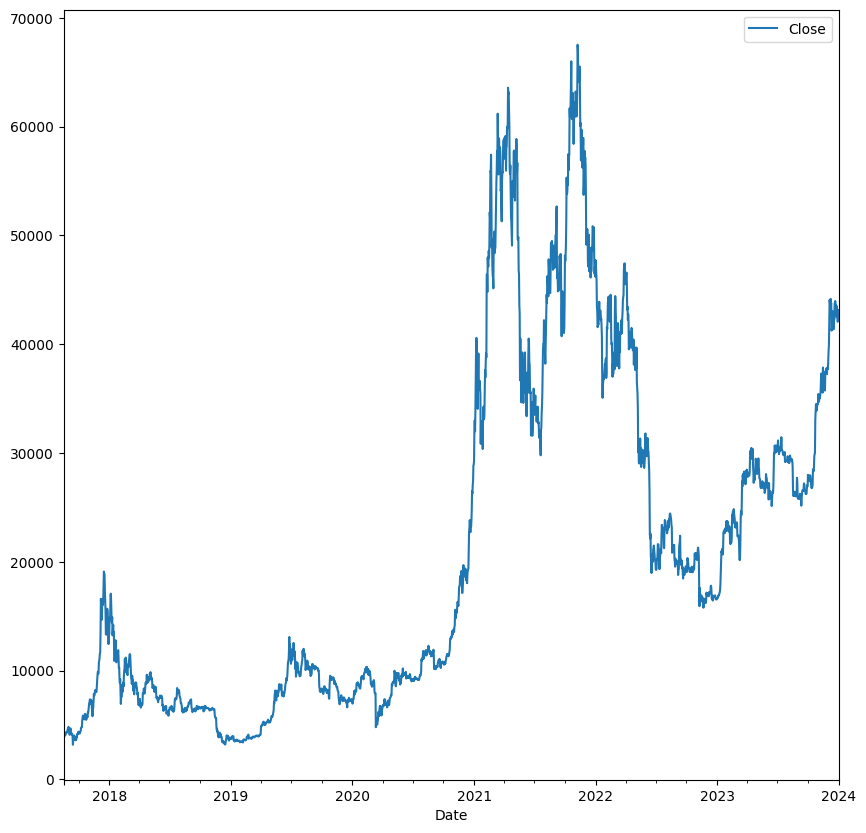

In [4]:
df = pd.DataFrame(crypto_data)
df.rename(columns={'Timestamp': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'] / 1000, unit='s')

df.plot.line(y='Close', x='Date', figsize=(10, 10))

data = df[['Close']]
data = data.rename(columns={'Close': 'Actual_Close'})
data['Target'] = df['Close'].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])
data['Date'] = df['Date']
data

In [5]:
print(df.head())
print(df.shape)
print(df.columns)

        Date     Open     High      Low    Close       Volume
0 2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
1 2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2 2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
3 2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
4 2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060
(2329, 6)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [6]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = ((delta.where(delta > 0, 0)).rolling(window=window).mean())
    loss = ((-delta.where(delta < 0, 0)).rolling(window=window).mean())
    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [7]:
df['RSI'] = calculate_rsi(df['Close'], 14)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
df

,Date,Open,High,Low,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,NaN,0.000000,0.000000,0.000000
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,NaN,-14.096524,-2.819305,-11.277219
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,NaN,-22.458570,-6.747158,-15.711412
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,NaN,-33.037055,-12.005137,-21.031918
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,NaN,-46.555731,-18.915256,-27.640475
...,...,...,...,...,...,...,...,...,...,...
2324,2023-12-28,43428.86,43787.57,42241.79,42563.76,35150.524850,47.729177,833.293046,1078.714285,-245.421239
2325,2023-12-29,42563.76,43111.00,41300.00,42066.95,42597.189120,50.665856,699.971599,1002.965748,-302.994149
2326,2023-12-30,42066.94,42612.32,41520.30,42140.28,22906.578180,49.255076,593.390275,921.050653,-327.660378
2327,2023-12-31,42140.29,42899.00,41965.84,42283.58,23585.916030,55.355575,514.555446,839.751612,-325.196166


In [8]:
def create_dataset(df, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(df)):
        x.append(df[i - sequence_length:i])
        y.append(df.iloc[i]['Close'])
    return np.array(x), np.array(y)

In [9]:
from keras.src.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from tensorflow.keras.layers import Dropout
from keras.src.layers import Conv1D, MaxPooling1D

df.dropna(subset=['RSI'], inplace=True)
if 'High' in df.columns and 'Low' in df.columns:
    df.drop(['High', 'Low'], axis=1, inplace=True)
features_columns = ['Close', 'Volume', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram']

sequence_length = 60
n_features = len(features_columns)

scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

df_scaled = scaler_features.fit_transform(df[features_columns])
df_scaled = pd.DataFrame(df_scaled, columns=features_columns)
print(df_scaled)

training_data_len = int(np.ceil(len(df_scaled) * 0.8))
train_data_scaled = scaler_features.transform(df_scaled[features_columns])
x_train, y_train = create_dataset(df_scaled[:training_data_len], sequence_length)
x_test, y_test = create_dataset(df_scaled[training_data_len:], sequence_length)

model = Sequential()
input_shape = (x_train.shape[1], x_train.shape[2])

# First convolutional layer for time series
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
# Final layer
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

         Close    Volume       RSI      MACD  Signal_Line  MACD_Histogram
0     0.021234  0.000672  0.611377  0.496451     0.496744        0.585124
1     0.023872  0.000341  0.665787  0.499024     0.498376        0.589072
2     0.025582  0.000346  0.806929  0.501804     0.500324        0.592797
3     0.019944  0.000831  0.594265  0.501062     0.501711        0.586179
4     0.020518  0.000518  0.628031  0.500657     0.502726        0.581804
...        ...       ...       ...       ...          ...             ...
2311  0.612010  0.045835  0.452681  0.572261     0.616926        0.488840
2312  0.604287  0.055628  0.483771  0.559344     0.608452        0.469843
2313  0.605427  0.029733  0.468835  0.549018     0.599288        0.461704
2314  0.607655  0.030626  0.533421  0.541380     0.590193        0.462517
2315  0.620904  0.020838  0.508148  0.541416     0.582925        0.484076

[2316 rows x 6 columns]
Epoch 1/100
57/57 [==============================] - 11s 96ms/step - loss: 0.2191 - val

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 4s 65ms/step - loss: 0.1153 - val_loss: 0.1060
Epoch 3/100
57/57 [==============================] - 4s 66ms/step - loss: 0.1014 - val_loss: 0.0855
Epoch 4/100
57/57 [==============================] - 4s 65ms/step - loss: 0.0909 - val_loss: 0.0684
Epoch 5/100
57/57 [==============================] - 4s 62ms/step - loss: 0.0832 - val_loss: 0.0555
Epoch 6/100
57/57 [==============================] - 4s 65ms/step - loss: 0.0784 - val_loss: 0.0465
Epoch 7/100
57/57 [==============================] - 4s 65ms/step - loss: 0.0755 - val_loss: 0.0399
Epoch 8/100
57/57 [==============================] - 4s 64ms/step - loss: 0.0736 - val_loss: 0.0345
Epoch 9/100
57/57 [==============================] - 4s 66ms/step - loss: 0.0726 - val_loss: 0.0313
Epoch 10/100
57/57 [==============================] - 4s 64ms/step - loss: 0.0721 - val_loss: 0.0291
Epoch 11/100
57/57 [==============================] - 4s 64ms/step - loss: 0.0719 - val_loss: 0.0278
Epoch 12/1

In [10]:



# scaler_volume = MinMaxScaler(feature_range=(0, 1))
# scaled_volume = scaler_volume.fit_transform(df['Volume'].values.reshape(-1,1))
# df[['RSI', 'MACD', 'Signal_Line', 'MACD_Histogram']] = scaler.fit_transform(df[['RSI', 'MACD', 'Signal_Line', 'MACD_Histogram']])

# drop column with NaN values

# df['RSI'].interpolate(inplace=True)


# df_scaled = df.copy()
# df_scaled.drop('Open', axis=1, inplace=True)
# x_train, y_train = [], []
# train_data = np.hstack((scaled_close, scaled_volume))
# 
# for i in range(sequence_length, len(train_data)):
#     x_train.append(train_data[i-sequence_length:i])
#     y_train.append(scaled_close[i, 0])
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
# 
# x_test, y_test = [], []
# scaled_data = np.hstack((scaled_close, scaled_volume)) 
# training_data_len = int(np.ceil(len(scaled_data) * 0.8))
# 
# test_data = scaled_data[training_data_len - sequence_length:, :] 
# 
# for i in range(sequence_length, len(test_data)):
#     x_test.append(test_data[i-sequence_length:i])  
#     y_test.append(test_data[i, 0]) 
# x_test, y_test = np.array(x_test), np.array(y_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2)) 
# log_dir = "logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Build LSTM network
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 2)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))

In [11]:
# Fit the scaler on the training data's features
scaler_features.fit(df[features_columns])

# If 'Close' is a column in 'features_columns', no need for a separate scaler
scaler_price.fit(df[['Close']])

# train_data_scaled = scaler_features.transform(df[features_columns])

# ... your code for splitting train_data_scaled into x_train and y_train ...

# Transform the last 60 days with the already fitted scaler
last_60_days_scaled = scaler_features.transform(df[-60:][features_columns])

# Reshape for the LSTM model
X_test = last_60_days_scaled.reshape((1, sequence_length, n_features))

# Predict the price
predicted_price = model.predict(X_test)

# Inverse transform the predicted price
predicted_price = scaler_price.inverse_transform(predicted_price)

print("Shape of model's output:", predicted_price.shape)
print("Inverse transformed price:", predicted_price)


1/1 [==============================] - 1s 1s/step
Shape of model's output: (1, 1)
Inverse transformed price: [[20536.988]]


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predicted = model.predict(x_test)
predicted_prices = scaler_price.inverse_transform(predicted)
real_values = scaler_price.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(real_values, predicted_prices)
mae = mean_absolute_error(real_values, predicted_prices)
r2 = r2_score(real_values, predicted_prices)

visualize = {
    'Real Values': real_values.flatten(),
    'Predicted Values': predicted_prices.flatten()
}

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")
df_vis = pd.DataFrame(visualize)
df_vis

13/13 [==============================] - 0s 22ms/step
MSE: 96551612.8149219, MAE: 8127.52082292959, R^2: -1.194034869962886


,Real Values,Predicted Values
0,16522.14,20536.933594
1,16458.57,20536.929688
2,16428.78,20536.927734
3,16212.91,20536.925781
4,16442.53,20536.923828
...,...,...
398,42563.76,20536.992188
399,42066.95,20536.992188
400,42140.28,20536.990234
401,42283.58,20536.990234


In [13]:
def calculate_percentage_error(real_values, predicted_values):
    percentage_errors = []
    for real, predicted in zip(real_values, predicted_values):
        if real != 0:  # Исключаем случай, когда реальное значение равно 0, так как это приведет к делению на ноль
            percentage_error = abs(real - predicted) / real * 100
            percentage_errors.append(percentage_error)
        else:
            percentage_errors.append(
                0)  # Можно выбрать другую логику для обработки случаев с нулевыми реальными значениями
    return percentage_errors


# Вычисление процентной ошибки
percentage_errors = calculate_percentage_error(real_values, predicted_prices)

# Для получения средней процентной ошибки по всему набору данных:
mean_percentage_error = sum(percentage_errors) / len(percentage_errors)


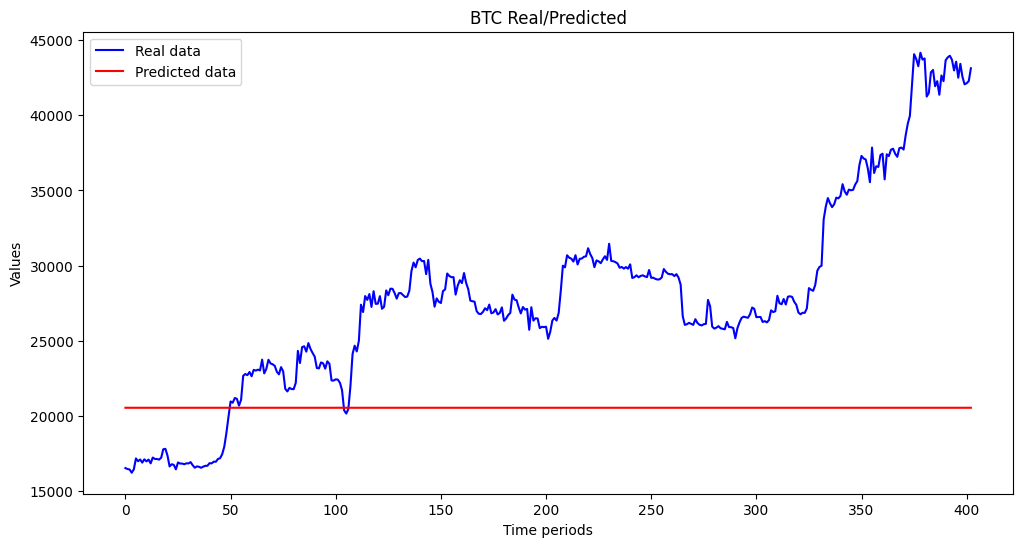

In [14]:
import matplotlib.pyplot as plt

# Create a range for the x-axis that matches the length of the data
time_periods = range(len(real_values))

plt.figure(figsize=(12, 6))
plt.plot(time_periods, real_values, color='blue', label='Real data')
plt.plot(time_periods, predicted_prices, color='red', label='Predicted data')

plt.title('BTC Real/Predicted')
plt.xlabel('Time periods')
plt.ylabel('Values')
plt.legend()
plt.show()


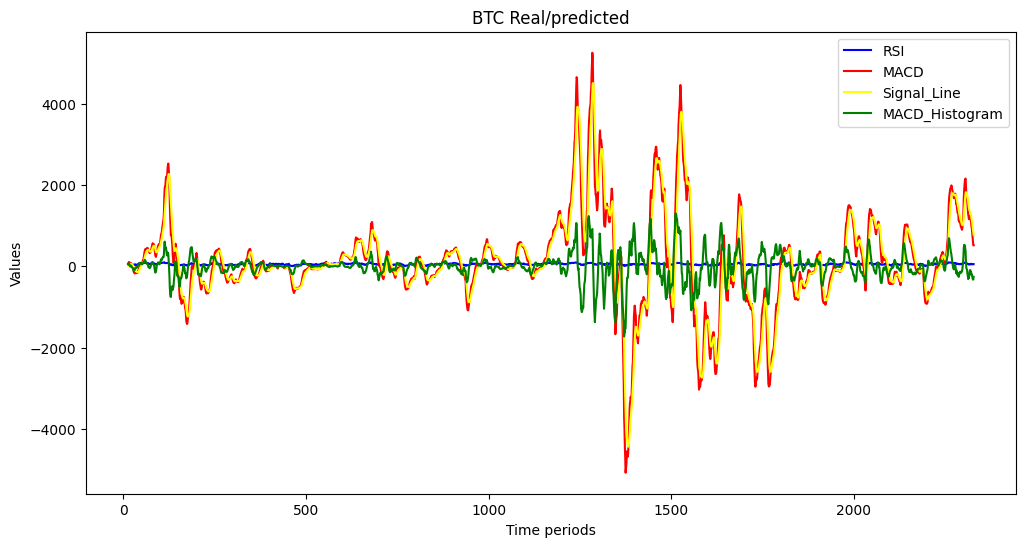

,Date,Open,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram
13,2017-08-30,4564.52,4555.14,808.468771,62.719001,50.819604,4.438057,46.381548
14,2017-08-31,4555.14,4724.89,556.956802,67.858274,77.372953,19.025036,58.347917
15,2017-09-01,4689.89,4834.91,560.666366,81.190006,106.071639,36.434357,69.637283
16,2017-09-02,4796.16,4472.14,929.148595,61.102643,98.408654,48.829216,49.579438
17,2017-09-03,4508.50,4509.08,691.216198,64.292040,94.230205,57.909414,36.320791
...,...,...,...,...,...,...,...,...
2324,2023-12-28,43428.86,42563.76,35150.524850,47.729177,833.293046,1078.714285,-245.421239
2325,2023-12-29,42563.76,42066.95,42597.189120,50.665856,699.971599,1002.965748,-302.994149
2326,2023-12-30,42066.94,42140.28,22906.578180,49.255076,593.390275,921.050653,-327.660378
2327,2023-12-31,42140.29,42283.58,23585.916030,55.355575,514.555446,839.751612,-325.196166


In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], color='blue', label='RSI')
plt.plot(df['MACD'], color='red', label='MACD')
plt.plot(df['Signal_Line'], color='yellow', label='Signal_Line')
plt.plot(df['MACD_Histogram'], color='green', label='MACD_Histogram')

plt.title('BTC Real/predicted')
plt.xlabel('Time periods')
plt.ylabel('Values')
plt.legend()

plt.show()

df

E:\SystemWin\TEMP\ipykernel_1620\2401779765.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['SMA_50'] = df['SMA_50'].fillna(method='bfill').fillna(method='ffill')
E:\SystemWin\TEMP\ipykernel_1620\2401779765.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['SMA_200'] = df['SMA_200'].fillna(method='bfill').fillna(method='ffill')


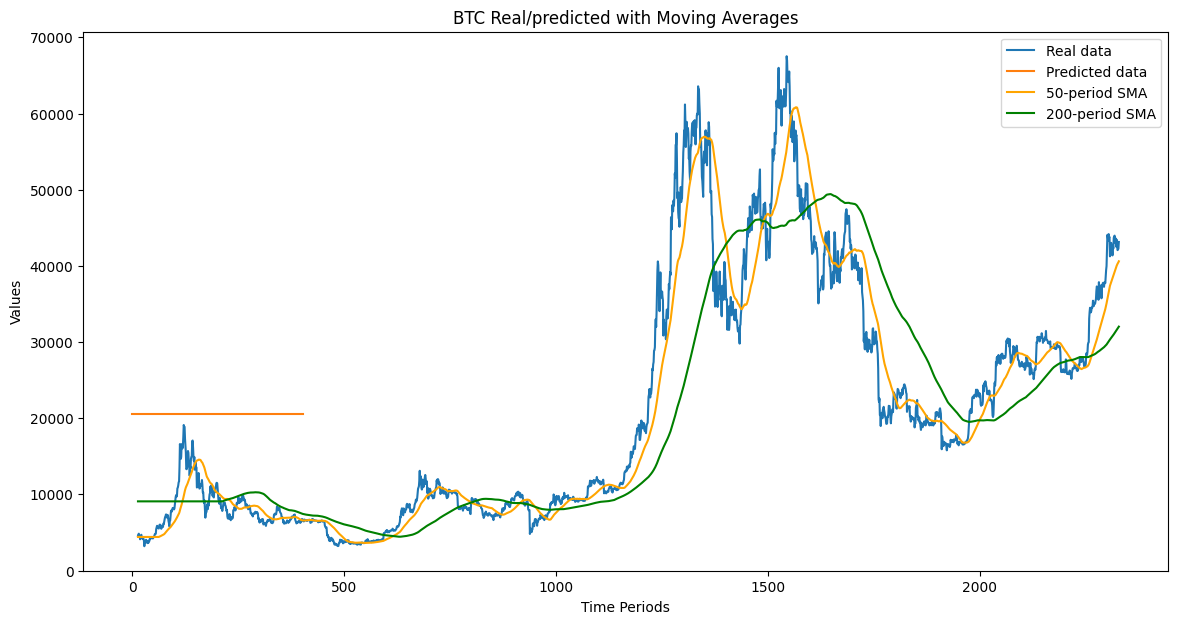

,Date,Open,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram,SMA_50,SMA_200
13,2017-08-30,4564.52,4555.14,808.468771,62.719001,50.819604,4.438057,46.381548,4406.0330,9079.75025
14,2017-08-31,4555.14,4724.89,556.956802,67.858274,77.372953,19.025036,58.347917,4406.0330,9079.75025
15,2017-09-01,4689.89,4834.91,560.666366,81.190006,106.071639,36.434357,69.637283,4406.0330,9079.75025
16,2017-09-02,4796.16,4472.14,929.148595,61.102643,98.408654,48.829216,49.579438,4406.0330,9079.75025
17,2017-09-03,4508.50,4509.08,691.216198,64.292040,94.230205,57.909414,36.320791,4406.0330,9079.75025
...,...,...,...,...,...,...,...,...,...,...
2324,2023-12-28,43428.86,42563.76,35150.524850,47.729177,833.293046,1078.714285,-245.421239,40171.2776,31685.90765
2325,2023-12-29,42563.76,42066.95,42597.189120,50.665856,699.971599,1002.965748,-302.994149,40278.5948,31766.71645
2326,2023-12-30,42066.94,42140.28,22906.578180,49.255076,593.390275,921.050653,-327.660378,40375.3678,31847.74660
2327,2023-12-31,42140.29,42283.58,23585.916030,55.355575,514.555446,839.751612,-325.196166,40478.4394,31933.52150


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_50'] = df['SMA_50'].fillna(method='bfill').fillna(method='ffill')

df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_200'] = df['SMA_200'].fillna(method='bfill').fillna(method='ffill')

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Real data')
plt.plot(predicted_prices, label='Predicted data')

plt.plot(df['SMA_50'], label='50-period SMA', color='orange')
plt.plot(df['SMA_200'], label='200-period SMA', color='green')

plt.title('BTC Real/predicted with Moving Averages')
plt.xlabel('Time Periods')
plt.ylabel('Values')

plt.legend()
plt.show()

df

In [17]:
import plotly.graph_objs as go
from plotly.offline import plot

trace_real = go.Scatter(
    x=list(range(len(real_values))),
    y=real_values,
    mode='lines',
    name='Real data',
    line=dict(color='#fe24ee')
)

real_data = go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Real Data'
)

predicted_data = go.Scatter(
    x=df.index,
    y=predicted_prices,
    mode='lines',
    name='Predicted Data'
)

SMA_50 = go.Scatter(
    x=df.index,
    y=df['SMA_50'],
    mode='lines',
    name='50-period SMA',
    line=dict(color='orange')
)

SMA_200 = go.Scatter(
    x=df.index,
    y=df['SMA_200'],
    mode='lines',
    name='200-period SMA',
    line=dict(color='green')
)

signal_line = go.Scatter(
    x=df.index,
    y=df['Signal_Line'],
    mode='lines',
    name='Signal_Line',
    line=dict(color='#ee2122')
)

MACD_histogram = go.Scatter(
    x=df.index,
    y=df['MACD_Histogram'],
    mode='lines',
    name='MACD_Histogram',
    line=dict(color='#f123e1')
)

MACD = go.Scatter(
    x=df.index,
    y=df['MACD'],
    mode='lines',
    name='MACD',
    line=dict(color='#11bbbb')
)

RSI = go.Scatter(
    x=df.index,
    y=df['RSI'],
    mode='lines',
    name='RSI',
    line=dict(color='#bb12bb')
)

trace_predicted = go.Scatter(
    x=list(range(len(predicted_prices))),
    y=predicted_prices,
    mode='lines',
    name='Predicted data',
    line=dict(color='red')
)

data = [trace_real, trace_predicted]

# Define the layout of the plot
layout = go.Layout(
    title='BTC Real/Predicted',
    xaxis=dict(title='Time periods'),
    yaxis=dict(title='Values'),
    legend=dict(x=0.1, y=0.9)
)

fig = go.Figure()

fig.add_trace(real_data)
fig.add_trace(predicted_data)
fig.add_trace(SMA_50)
fig.add_trace(SMA_200)
fig.add_trace(signal_line)
fig.add_trace(MACD_histogram)
fig.add_trace(MACD)
fig.add_trace(RSI)

fig.update_layout(
    title='BTC Real/Predicted with Moving Averages',
    xaxis_title='Time Periods',
    yaxis_title='Values',
    hovermode='x'
)

plot(fig, filename='interactive_graph.html')


'interactive_graph.html'

In [18]:
#######################################

In [19]:
crypto_data

,Timestamp,Open,High,Low,Close,Volume
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...,...
2324,1703721600000,43428.86,43787.57,42241.79,42563.76,35150.524850
2325,1703808000000,42563.76,43111.00,41300.00,42066.95,42597.189120
2326,1703894400000,42066.94,42612.32,41520.30,42140.28,22906.578180
2327,1703980800000,42140.29,42899.00,41965.84,42283.58,23585.916030


In [20]:
# set params for Bollinger Bands (BB)
sma_period = 20  #using for 20-period SMA
std_dev_multiplier = 2  #standart deviation

df['Low'] = crypto_data['Low']
df['High'] = crypto_data['High']

# calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=sma_period).mean()
df['Upper_BB'] = df['SMA'] + df['Close'].rolling(window=sma_period).std() * std_dev_multiplier
df['Lower_BB'] = df['SMA'] - df['Close'].rolling(window=sma_period).std() * std_dev_multiplier

# Calculate the Money Flow Index (MFI)
typical_price = (df['Close'] + df['Low'] + df['High']) / 3
raw_money_flow = typical_price * df['Volume']
positive_flow = raw_money_flow.where(typical_price > typical_price.shift(1), 0)
negative_flow = raw_money_flow.where(typical_price < typical_price.shift(1), 0)

# Calculate the money flow ratio
positive_flow_sum = positive_flow.rolling(window=14).sum()
negative_flow_sum = negative_flow.rolling(window=14).sum()
money_flow_ratio = positive_flow_sum / negative_flow_sum

# Calculate the MFI
mfi = 100 - (100 / (1 + money_flow_ratio))
df['MFI'] = mfi

# set params for Relative Volatility Index (RVI)
rvi_period = 10  # define the period for RVI, for example 10

# calculate Relative Volatility Index (RVI)
standard_deviation = df['Close'].rolling(window=rvi_period).std()
mean_deviation = standard_deviation.rolling(window=rvi_period).mean()
df['RVI'] = standard_deviation / mean_deviation.where(mean_deviation != 0, np.nan)

# remove starting NA values after calculate indicators
df.dropna(inplace=True)

In [21]:
df

,Date,Open,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram,SMA_50,SMA_200,Low,High,SMA,Upper_BB,Lower_BB,MFI,RVI
32,2017-09-18,3690.00,4035.01,1030.006455,48.958800,-156.191648,-103.250397,-52.941251,4406.0330,9079.75025,3690.00,4123.20,4210.0975,5042.872610,3377.322390,44.214191,1.080327
33,2017-09-19,4060.00,3910.04,902.332129,42.354120,-148.398764,-112.280070,-36.118693,4406.0330,9079.75025,3830.91,4089.97,4177.8425,5004.295390,3351.389610,45.474232,0.978981
34,2017-09-20,3910.04,3900.00,720.935076,36.872937,-141.402985,-118.104653,-23.298332,4406.0330,9079.75025,3820.00,4046.08,4136.5980,4929.763426,3343.432574,39.315184,0.921318
35,2017-09-21,3889.99,3609.99,1001.654084,31.727663,-157.445233,-125.972769,-31.472463,4406.0330,9079.75025,3567.00,3910.00,4075.3520,4829.698563,3321.005437,34.078954,0.835031
36,2017-09-22,3592.84,3595.87,838.966425,36.609708,-169.346079,-134.647431,-34.698648,4406.0330,9079.75025,3505.55,3750.00,4031.5385,4790.624351,3272.452649,35.298268,0.735832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2023-12-28,43428.86,42563.76,35150.524850,47.729177,833.293046,1078.714285,-245.421239,40171.2776,31685.90765,42241.79,43787.57,42846.9030,44594.188607,41099.617393,57.091399,0.768854
2325,2023-12-29,42563.76,42066.95,42597.189120,50.665856,699.971599,1002.965748,-302.994149,40278.5948,31766.71645,41300.00,43111.00,42764.5705,44495.002353,41034.138647,56.022317,0.833291
2326,2023-12-30,42066.94,42140.28,22906.578180,49.255076,593.390275,921.050653,-327.660378,40375.3678,31847.74660,41520.30,42612.32,42682.1090,44363.375006,41000.842994,56.169259,0.920088
2327,2023-12-31,42140.29,42283.58,23585.916030,55.355575,514.555446,839.751612,-325.196166,40478.4394,31933.52150,41965.84,42899.00,42733.6180,44288.993431,41178.242569,61.518827,0.913708


In [22]:
import requests
import pandas as pd


def get_blockchain_data():
    url = 'https://api.blockchain.info/stats'
    response = requests.get(url)
    data = response.json()
    blockchain_data = pd.DataFrame([data])
    blockchain_data = blockchain_data[['hash_rate']]
    blockchain_data['Date'] = pd.to_datetime('today')
    return blockchain_data


blockchain_data = get_blockchain_data()

df['Date'] = pd.to_datetime(df['Date'])
current_hash_rate = blockchain_data.at[0, 'hash_rate']
df['hash_rate'] = current_hash_rate

df

,Date,Open,Close,Volume,RSI,MACD,Signal_Line,MACD_Histogram,SMA_50,SMA_200,Low,High,SMA,Upper_BB,Lower_BB,MFI,RVI,hash_rate
32,2017-09-18,3690.00,4035.01,1030.006455,48.958800,-156.191648,-103.250397,-52.941251,4406.0330,9079.75025,3690.00,4123.20,4210.0975,5042.872610,3377.322390,44.214191,1.080327,5.082812e+11
33,2017-09-19,4060.00,3910.04,902.332129,42.354120,-148.398764,-112.280070,-36.118693,4406.0330,9079.75025,3830.91,4089.97,4177.8425,5004.295390,3351.389610,45.474232,0.978981,5.082812e+11
34,2017-09-20,3910.04,3900.00,720.935076,36.872937,-141.402985,-118.104653,-23.298332,4406.0330,9079.75025,3820.00,4046.08,4136.5980,4929.763426,3343.432574,39.315184,0.921318,5.082812e+11
35,2017-09-21,3889.99,3609.99,1001.654084,31.727663,-157.445233,-125.972769,-31.472463,4406.0330,9079.75025,3567.00,3910.00,4075.3520,4829.698563,3321.005437,34.078954,0.835031,5.082812e+11
36,2017-09-22,3592.84,3595.87,838.966425,36.609708,-169.346079,-134.647431,-34.698648,4406.0330,9079.75025,3505.55,3750.00,4031.5385,4790.624351,3272.452649,35.298268,0.735832,5.082812e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2023-12-28,43428.86,42563.76,35150.524850,47.729177,833.293046,1078.714285,-245.421239,40171.2776,31685.90765,42241.79,43787.57,42846.9030,44594.188607,41099.617393,57.091399,0.768854,5.082812e+11
2325,2023-12-29,42563.76,42066.95,42597.189120,50.665856,699.971599,1002.965748,-302.994149,40278.5948,31766.71645,41300.00,43111.00,42764.5705,44495.002353,41034.138647,56.022317,0.833291,5.082812e+11
2326,2023-12-30,42066.94,42140.28,22906.578180,49.255076,593.390275,921.050653,-327.660378,40375.3678,31847.74660,41520.30,42612.32,42682.1090,44363.375006,41000.842994,56.169259,0.920088,5.082812e+11
2327,2023-12-31,42140.29,42283.58,23585.916030,55.355575,514.555446,839.751612,-325.196166,40478.4394,31933.52150,41965.84,42899.00,42733.6180,44288.993431,41178.242569,61.518827,0.913708,5.082812e+11


In [57]:
import requests
from textblob import TextBlob

def fetch_news(api_key, query):
    # Запрос к API для получения новостей
    url = f"https://newsapi.org/v2/everything?q={query}&apiKey={api_key}"
    response = requests.get(url)
    articles = response.json().get('articles', [])
    return articles

def analyze_sentiment(articles):
    sentiments = []
    for article in articles:
        analysis = TextBlob(article['description'])
        sentiments.append(analysis.sentiment.polarity)
    return sentiments

api_key = 'YOUR_API_KEY'  # Замените на ваш ключ API
crypto_news = fetch_news(api_key, 'bitcoin')
sentiments = analyze_sentiment(crypto_news)

# Добавьте средний сентимент в качестве признака в вашу модель
average_sentiment = sum(sentiments) / len(sentiments)

ModuleNotFoundError: No module named 'textblob'

In [23]:
X = df[features_columns]
y = df['Close']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# range in which we can search for a value




In [55]:
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data preparation
df.dropna(subset=['RSI'], inplace=True)
df.drop(['High', 'Low'], axis=1, errors='ignore', inplace=True)
df['Mid_Price'] = (df['Open'] + df['Close']) / 2

# Calculate SMA_50 and add to df
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Update your features list
features_columns = ['Close', 'Volume', 'Signal_Line', 'Mid_Price', 'SMA_50', 'SMA_200', 'MACD']

# Handling any NaN values
df.dropna(inplace=True)

# Normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler_features.fit_transform(df[features_columns])
df_scaled = pd.DataFrame(df_scaled, columns=features_columns)


# Define create_dataset function
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back, 0])  # Assuming 'Close' is at index 0
    return np.array(X), np.array(Y)


# Prepare the dataset
look_back = 60
X, Y = create_dataset(df_scaled.values, look_back)

# Splitting data to training and testing sets
training_data_len = int(len(df_scaled) * 0.8)
X_train, X_test, Y_train, Y_test = X[:training_data_len], X[training_data_len:], Y[:training_data_len], Y[training_data_len:]

# Define the GRU model
n_features = len(features_columns)
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(GRU(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Fit the model
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/100
21/21 [==============================] - 11s 156ms/step - loss: 0.0199 - val_loss: 0.0013
Epoch 2/100


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



21/21 [==============================] - 2s 94ms/step - loss: 0.0071 - val_loss: 4.2915e-04
Epoch 3/100
21/21 [==============================] - 2s 97ms/step - loss: 0.0057 - val_loss: 3.8952e-04
Epoch 4/100
21/21 [==============================] - 2s 92ms/step - loss: 0.0048 - val_loss: 3.4032e-04
Epoch 5/100
21/21 [==============================] - 2s 90ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 6/100
21/21 [==============================] - 2s 80ms/step - loss: 0.0043 - val_loss: 5.5596e-04
Epoch 7/100
21/21 [==============================] - 2s 87ms/step - loss: 0.0036 - val_loss: 3.2351e-04
Epoch 8/100
21/21 [==============================] - 2s 94ms/step - loss: 0.0040 - val_loss: 3.1162e-04
Epoch 9/100
21/21 [==============================] - 2s 82ms/step - loss: 0.0036 - val_loss: 5.4554e-04
Epoch 10/100
21/21 [==============================] - 2s 81ms/step - loss: 0.0032 - val_loss: 9.7937e-04
Epoch 11/100
21/21 [==============================] - 2s 79ms/step - loss: 0.00

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure X_test is used for prediction, and it has the correct shape
predicted = model.predict(X_test)

# Inverse transform the predicted and real values
# Make sure scaler_price was fitted to the 'Close' prices initially
predicted_prices = scaler_price.inverse_transform(predicted)
real_values = scaler_price.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(real_values, predicted_prices)
mae = mean_absolute_error(real_values, predicted_prices)
r2 = r2_score(real_values, predicted_prices)

# Prepare data for visualization
visualize = {
    'real': real_values.flatten(),
    'predicted': predicted_prices.flatten()
}

# Print evaluation metrics
print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

# Create a DataFrame for visualization
df_vis = pd.DataFrame(visualize)
df_vis


# results: MSE: 651167, MAR:559.13, R^2: 0.9786

9/9 [==============================] - 3s 18ms/step
MSE: 651167.8487387454, MAE: 559.1343736801305, R^2: 0.9786288385683106


,real,predicted
0,29515.150698,29414.367188
1,29338.897351,29643.798828
2,29348.702880,29734.593750
3,28451.866283,29689.962891
4,29425.998342,29283.781250
...,...,...
258,41922.662138,42451.035156
259,41413.092626,42253.484375
260,41488.305951,41826.351562
261,41635.286308,41568.796875


In [26]:
# Берем последние данные из x_test 559.134
last_sequence = x_test[-1:]

# Список для хранения предсказаний
future_predictions = []

# Прогнозирование на следующие 10 дней
for _ in range(10):
    # Сделать предсказание
    current_pred = model.predict(last_sequence)

    # Добавляем предсказание в список будущих предсказаний
    future_predictions.append(current_pred[0, 0])

    # Обновляем последнюю последовательность данных
    # Копируем последнюю последовательность и обновляем последний признак (предсказание)
    new_sequence = np.roll(last_sequence, -1, axis=1)
    new_sequence[0, -1, :] = np.zeros(last_sequence.shape[2])  # обнуляем последний набор признаков
    new_sequence[0, -1, 0] = current_pred[0, 0]  # обновляем только признак цены закрытия

    last_sequence = new_sequence

# Денормализация предсказаний
future_prices = scaler_price.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Вывод предсказаний
for i, price in enumerate(future_prices):
    print(f"Day {i + 1}: Predicted Price - {price[0]}")


InvalidArgumentError: Graph execution error:

Detected at node while/body/_1/while/BiasAdd defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,6], In[1]: [5,300]
	 [[{{node while/body/_1/while/BiasAdd}}]]
	 [[sequential_1/gru/PartitionedCall]] [Op:__inference_predict_function_37996]

In [51]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_50'] = df['SMA_50'].fillna(method='bfill').fillna(method='ffill')

df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_200'] = df['SMA_200'].fillna(method='bfill').fillna(method='ffill')


E:\SystemWin\TEMP\ipykernel_1620\1952949804.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

E:\SystemWin\TEMP\ipykernel_1620\1952949804.py:5: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [52]:
import plotly.graph_objs as go
from plotly.offline import plot
import matplotlib.pyplot as plt


real_data = go.Scatter(
    x=df.index, 
    y=df['Close'], 
    mode='lines',
    name='Real Data'
)

predicted_data = go.Scatter(
    x=df.index, 
    y=predicted_prices, 
    mode='lines',
    name='Predicted Data'
)

SMA_50 = go.Scatter(
    x=df.index, 
    y=df['SMA_50'], 
    mode='lines',
    name='50-period SMA',
    line=dict(color='orange')
)

SMA_200 = go.Scatter(
    x=df.index, 
    y=df['SMA_200'], 
    mode='lines',
    name='200-period SMA',
    line=dict(color='green')
)

signal_line = go.Scatter(
    x=df.index, 
    y=df['Signal_Line'], 
    mode='lines',
    name='Signal_Line',
    line=dict(color='#ee2122')
)

MACD_histogram = go.Scatter(
    x=df.index, 
    y=df['MACD_Histogram'], 
    mode='lines',
    name='MACD_Histogram',
    line=dict(color='#f123e1')
)

MACD = go.Scatter(
    x=df.index, 
    y=df['MACD'], 
    mode='lines',
    name='MACD',
    line=dict(color='#11bbbb')
)

RSI = go.Scatter(
    x=df.index, 
    y=df['RSI'], 
    mode='lines',
    name='RSI',
    line=dict(color='#bb12bb')
)

fig = go.Figure()

fig.add_trace(real_data)
fig.add_trace(predicted_data)
fig.add_trace(SMA_50)
fig.add_trace(SMA_200)
fig.add_trace(signal_line)
fig.add_trace(MACD_histogram)
fig.add_trace(MACD)
fig.add_trace(RSI)

fig.update_layout(
    title='BTC Real/Predicted with Moving Averages',
    xaxis_title='Time Periods',
    yaxis_title='Values',
    hovermode='x'
)

plot(fig, filename='interactive_graph.html')


'interactive_graph.html'

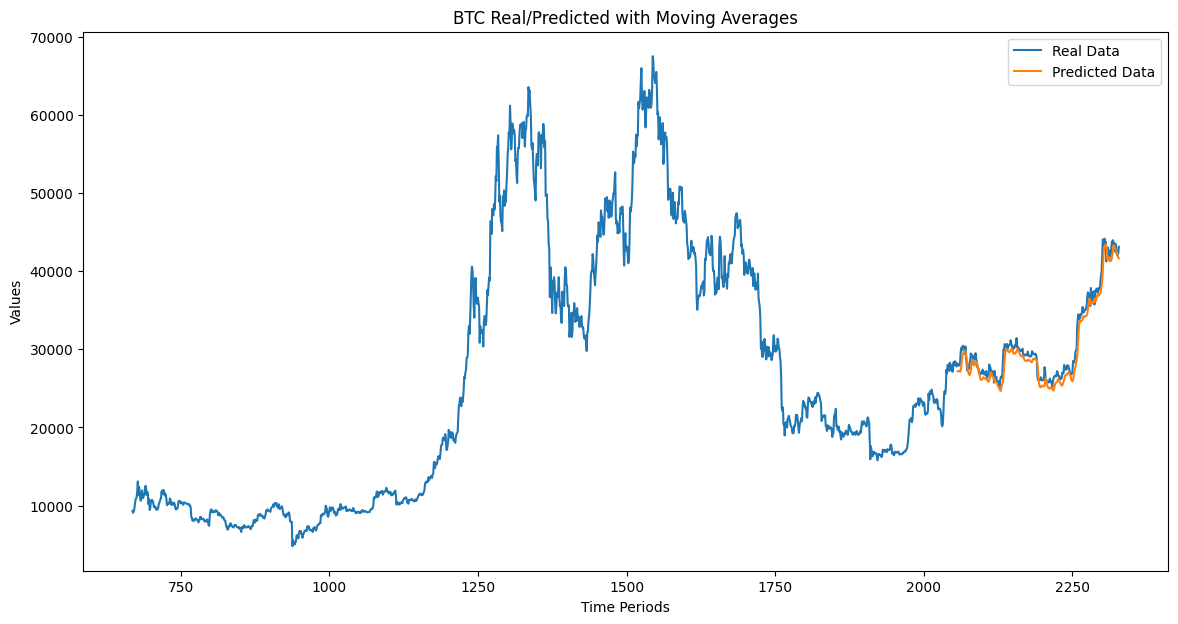

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Определение SMA
df['SMA_50'] = df['Close'].rolling(window=50).mean().bfill().ffill()
df['SMA_200'] = df['Close'].rolling(window=200).mean().bfill().ffill()

# Расчет индекса для предсказанных цен
start_point = training_data_len + sequence_length
end_point = start_point + len(predicted_prices)
predicted_index = df.index[start_point:end_point]

# Создание DataFrame для предсказанных цен
# Предполагаем, что predicted_prices - это массив numpy, полученный после обратного масштабирования
predicted_df = pd.DataFrame(predicted_prices, index=predicted_index, columns=['Predicted'])

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Real Data')
plt.plot(predicted_df['Predicted'], label='Predicted Data')

# Ваши линии для SMA, если вы хотите их добавить
# plt.plot(df['SMA_50'], label='50-period SMA', color='orange') 
# plt.plot(df['SMA_200'], label='200-period SMA', color='green')

# Настройки графика
plt.title('BTC Real/Predicted with Moving Averages')
plt.xlabel('Time Periods')
plt.ylabel('Values')
plt.legend()

# Отображение графика
plt.show()


In [54]:
import plotly.graph_objs as go
from plotly.offline import plot
import matplotlib.pyplot as plt

predicted_index = df.index[start_point:end_point]
predicted_prices_series = pd.Series(predicted_prices.flatten(), index=predicted_index)

df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_50'] = df['SMA_50'].fillna(method='bfill').fillna(method='ffill')

df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_200'] = df['SMA_200'].fillna(method='bfill').fillna(method='ffill')

real_data = go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Real Data'
)

predicted_data = go.Scatter(
    x=predicted_index,
    y=predicted_prices_series,
    mode='lines',
    name='Predicted Data'
)

SMA_50 = go.Scatter(
    x=df.index,
    y=df['SMA_50'],
    mode='lines',
    name='50-period SMA',
    line=dict(color='orange')
)

SMA_200 = go.Scatter(
    x=df.index,
    y=df['SMA_200'],
    mode='lines',
    name='200-period SMA',
    line=dict(color='green')
)

signal_line = go.Scatter(
    x=df.index,
    y=df['Signal_Line'],
    mode='lines',
    name='Signal_Line',
    line=dict(color='#ee2122')
)

MACD_histogram = go.Scatter(
    x=df.index,
    y=df['MACD_Histogram'],
    mode='lines',
    name='MACD_Histogram',
    line=dict(color='#f123e1')
)

MACD = go.Scatter(
    x=df.index,
    y=df['MACD'],
    mode='lines',
    name='MACD',
    line=dict(color='#11bbbb')
)

RSI = go.Scatter(
    x=df.index,
    y=df['RSI'],
    mode='lines',
    name='RSI',
    line=dict(color='#bb12bb')
)

fig = go.Figure()

fig.add_trace(real_data)
fig.add_trace(predicted_data)
fig.add_trace(SMA_50)
fig.add_trace(SMA_200)
fig.add_trace(signal_line)
fig.add_trace(MACD_histogram)
fig.add_trace(MACD)
fig.add_trace(RSI)

fig.update_layout(
    title='BTC Real/Predicted with Moving Averages',
    xaxis_title='Time Periods',
    yaxis_title='Values',
    hovermode='x'
)

plot(fig, filename='interactive_graph.html')


E:\SystemWin\TEMP\ipykernel_1620\48571461.py:9: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

E:\SystemWin\TEMP\ipykernel_1620\48571461.py:12: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



'interactive_graph.html'

In [ ]:
# # Предполагаем, что df_scaled - это ваш масштабированный DataFrame
# features_importance = {}
# original_features = features_columns.copy()
# 
# for feature in original_features:
#     # Удалить признак из набора данных
#     temp_features = original_features.copy()
#     temp_features.remove(feature)
#     temp_df_scaled = df_scaled[temp_features]
# 
#     # Подготовить новые наборы данных
#     x_train_temp, y_train_temp = create_dataset(temp_df_scaled[:training_data_len], sequence_length)
#     x_test_temp, y_test_temp = create_dataset(temp_df_scaled[training_data_len:], sequence_length)
# 
#     # Обучить модель
#     temp_model = build_model(sequence_length, len(temp_features))  # функция build_model должна быть определена
#     temp_model.fit(x_train_temp, y_train_temp, epochs=100, batch_size=32, validation_data=(x_test_temp, y_test_temp), callbacks=[early_stopping, model_checkpoint])
# 
#     # Оценить производительность
#     predictions_temp = temp_model.predict(x_test_temp)
#     mse_temp = mean_squared_error(y_test_temp, predictions_temp)
# 
#     # Сохранить изменение производительности
#     features_importance[feature] = baseline_mse - mse_temp
# 
# # Отобразить изменение производительности
# plt.barh(range(len(features_importance)), list(features_importance.values()), align='center')
# plt.yticks(range(len(features_importance)), list(features_importance.keys()))
# plt.xlabel('Изменение MSE')
# plt.title('Изменение производительности после удаления признака')
# plt.show()
